In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.8D5SAX_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.8D5SAX_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [5]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [6]:
import tensorflow as tf

def augment(image, label):
    # 랜덤 수평 뒤집기
    image = tf.image.random_flip_left_right(image)

    # 밝기 변화 (±0.1)
    image = tf.image.random_brightness(image, max_delta=0.1)

    # 대비 변화 (0.9~1.1배)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    # 회전 (90도 단위)
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)

    return image, label

In [7]:
num_classes = ds_info.features["label"].num_classes
def build_resnet50_model():
    return keras.models.Sequential([
        keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3),
            pooling='avg'
        ),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

In [8]:
resnet50 = build_resnet50_model()
aug_resnet50 = build_resnet50_model()
aug_cutmix_resnet50 = build_resnet50_model()
aug_mixup_resnet50 = build_resnet50_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [9]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [10]:
ds_test = ds_test.map(lambda x: (x['image'], x['label']))
ds_test = ds_test.map(normalize_and_resize_img)
ds_test = ds_test.map(onehot)
ds_test = ds_test.batch(16).prefetch(tf.data.AUTOTUNE)

In [11]:
def cutmix(images, labels, alpha=1.0):
    lam = tfp.distributions.Beta(alpha, alpha).sample([1])[0]
    lam = tf.cast(lam, tf.float32)
    batch_size = tf.shape(images)[0]

    index = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(images, index)
    shuffled_labels = tf.gather(labels, index)

    h = tf.shape(images)[1]
    w = tf.shape(images)[2]

    rx = tf.random.uniform([], 0, w, dtype=tf.int32)
    ry = tf.random.uniform([], 0, h, dtype=tf.int32)

    #  최소 1픽셀 이상 크기를 보장
    rw = tf.maximum(tf.cast(tf.cast(w, tf.float32) * tf.math.sqrt(1. - lam), tf.int32), 1)
    rh = tf.maximum(tf.cast(tf.cast(h, tf.float32) * tf.math.sqrt(1. - lam), tf.int32), 1)

    x1 = tf.clip_by_value(rx - rw // 2, 0, w)
    y1 = tf.clip_by_value(ry - rh // 2, 0, h)
    x2 = tf.clip_by_value(rx + rw // 2, 0, w)
    y2 = tf.clip_by_value(ry + rh // 2, 0, h)

    #  보장된 마스크 크기
    mask_height = tf.maximum(y2 - y1, 1)
    mask_width = tf.maximum(x2 - x1, 1)

    mask = tf.ones((mask_height, mask_width, 3), dtype=tf.float32)
    pad_mask = tf.image.pad_to_bounding_box(mask, y1, x1, h, w)

    images = images * (1. - pad_mask) + shuffled_images * pad_mask

    labels = tf.cast(labels, tf.float32)
    shuffled_labels = tf.cast(shuffled_labels, tf.float32)
    labels = labels * lam + shuffled_labels * (1. - lam)

    return images, labels


In [12]:
# Mixup 함수
def mixup(images, labels, alpha=0.2):
    lam = tfp.distributions.Beta(alpha, alpha).sample([1])[0]
    batch_size = tf.shape(images)[0]
    index = tf.random.shuffle(tf.range(batch_size))
    mixed_images = lam * images + (1 - lam) * tf.gather(images, index)
    mixed_labels = lam * labels + (1 - lam) * tf.gather(labels, index)
    return mixed_images, mixed_labels

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    # dict → (image, label)
    ds = ds.map(lambda x: (x['image'], x['label']), num_parallel_calls=tf.data.AUTOTUNE)

    # normalize
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=tf.data.AUTOTUNE)

    # augmentation
    if not is_test and with_aug:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    # batching
    ds = ds.batch(batch_size)

    # onehot → cutmix/mixup
    if not is_test:
        ds = ds.map(onehot, num_parallel_calls=tf.data.AUTOTUNE)
        if with_cutmix:
            ds = ds.map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
        elif with_mixup:
            ds = ds.map(mixup, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(200)
        ds = ds.repeat()

    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


In [14]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train,
                                      with_aug=False)

ds_train_aug = apply_normalize_on_dataset(ds_train,
                                      with_aug=True)

ds_train_cutmix = apply_normalize_on_dataset(ds_train,
                                      with_aug=True,
                                      with_cutmix=True)

ds_train_mixup = apply_normalize_on_dataset(ds_train,
                                      with_aug=True,
                                      with_mixup=True)

In [15]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 162s 177ms/step - accuracy: 0.2816 - loss: 3.1704 - val_accuracy: 0.1093 - val_loss: 4.0204
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 131s 174ms/step - accuracy: 0.7509 - loss: 0.9006 - val_accuracy: 0.6479 - val_loss: 1.2410
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 130s 174ms/step - accuracy: 0.9236 - loss: 0.3324 - val_accuracy: 0.6590 - val_loss: 1.1847
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 130s 174ms/step - accuracy: 0.9791 - loss: 0.1283 - val_accuracy: 0.7178 - val_loss: 0.9787
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 131s 174ms/step - accuracy: 0.9955 - loss: 0.0558 - val_accuracy: 0.7350 - val_loss: 0.9278
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 131s 174ms/step - accuracy: 0.9976 - loss: 0.0307 - val_accuracy: 0.7385 - val_loss: 0.9401
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 130s 174ms/step - accuracy: 0.9983 - loss: 0.0208 - val_accuracy: 0.7410 - val_loss: 0.9368
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 130s 174ms/step - accuracy: 0.9988 -

In [16]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    validation_data=ds_test,
    epochs=EPOCH,
    verbose=1,
)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 158s 181ms/step - accuracy: 0.1480 - loss: 3.8697 - val_accuracy: 0.1823 - val_loss: 3.4083
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 175ms/step - accuracy: 0.4887 - loss: 1.8380 - val_accuracy: 0.4473 - val_loss: 2.0074
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.5954 - loss: 1.4159 - val_accuracy: 0.4747 - val_loss: 1.9640
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.6843 - loss: 1.0902 - val_accuracy: 0.5606 - val_loss: 1.5435
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 175ms/step - accuracy: 0.7256 - loss: 0.9241 - val_accuracy: 0.5689 - val_loss: 1.5964
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.7765 - loss: 0.7710 - val_accuracy: 0.5585 - val_loss: 1.6430
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.8251 - loss: 0.6072 - val_accuracy: 0.5438 - val_loss: 1.7667
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.8527 -

In [17]:
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation & cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    validation_data=ds_test,
    epochs=EPOCH,
    verbose=1,
)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 159s 181ms/step - accuracy: 0.0567 - loss: 4.6181 - val_accuracy: 0.1544 - val_loss: 3.6585
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.2305 - loss: 3.6291 - val_accuracy: 0.5250 - val_loss: 1.7345
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.2999 - loss: 3.3880 - val_accuracy: 0.5620 - val_loss: 1.5836
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.3472 - loss: 3.1784 - val_accuracy: 0.5672 - val_loss: 1.6444
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.3523 - loss: 3.1484 - val_accuracy: 0.4557 - val_loss: 2.0634
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.4081 - loss: 2.9604 - val_accuracy: 0.5363 - val_loss: 1.7632
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.4204 - loss: 2.8765 - val_accuracy: 0.5667 - val_loss: 1.6214
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.4579 -

In [18]:
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_mixup, # augmentation & mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    validation_data=ds_test,
    epochs=EPOCH,
    verbose=1,
)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 159s 181ms/step - accuracy: 0.1157 - loss: 4.1332 - val_accuracy: 0.1382 - val_loss: 3.8014
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.4229 - loss: 2.5284 - val_accuracy: 0.4789 - val_loss: 1.9017
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.5453 - loss: 2.0997 - val_accuracy: 0.5273 - val_loss: 1.6601
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.5968 - loss: 1.9671 - val_accuracy: 0.5456 - val_loss: 1.6359
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.6585 - loss: 1.7394 - val_accuracy: 0.6032 - val_loss: 1.3856
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.6977 - loss: 1.6113 - val_accuracy: 0.5849 - val_loss: 1.5024
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.7465 - loss: 1.4661 - val_accuracy: 0.5709 - val_loss: 1.5371
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.7594 -

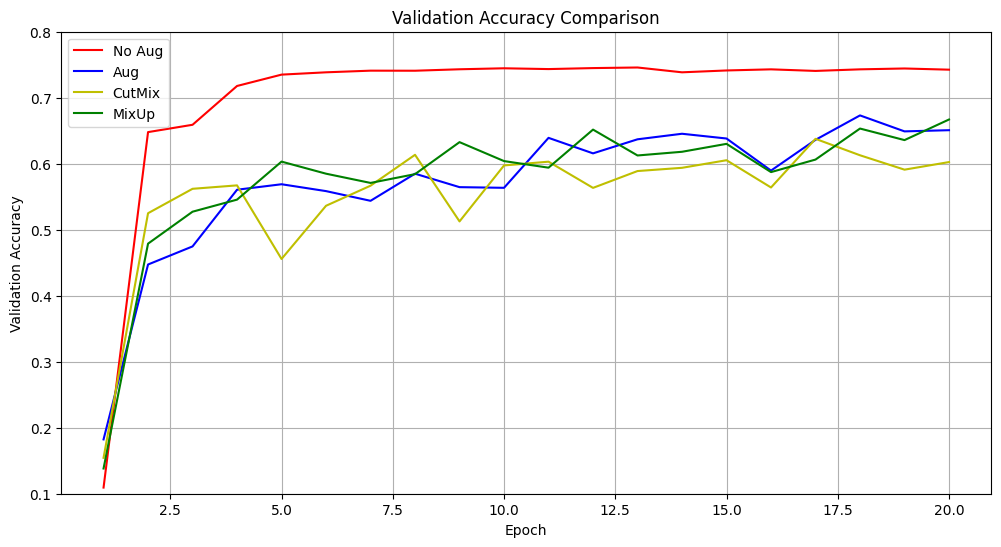

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# 각 모델의 val_accuracy
val_acc_no_aug = [0.1093, 0.6479, 0.6590, 0.7178, 0.7350, 0.7385, 0.7410, 0.7409, 0.7431, 0.7446,
                  0.7434, 0.7449, 0.7458, 0.7385, 0.7413, 0.7430, 0.7406, 0.7430, 0.7443, 0.7425]
val_acc_aug = [0.1823, 0.4473, 0.4747, 0.5606, 0.5689, 0.5585, 0.5438, 0.5849, 0.5645, 0.5635,
               0.6392, 0.6157, 0.6370, 0.6454, 0.6382, 0.5896, 0.6362, 0.6732, 0.6490, 0.6508]
val_acc_cutmix = [0.1544, 0.5250, 0.5620, 0.5672, 0.4557, 0.5363, 0.5667, 0.6135, 0.5126, 0.5974,
                  0.6031, 0.5634, 0.5889, 0.5938, 0.6053, 0.5640, 0.6377, 0.6128, 0.5910, 0.6025]
val_acc_mixup = [0.1382, 0.4789, 0.5273, 0.5456, 0.6032, 0.5849, 0.5709, 0.5842, 0.6327, 0.6040,
                 0.5940, 0.6517, 0.6125, 0.6181, 0.6301, 0.5873, 0.6063, 0.6533, 0.6358, 0.6670]

epochs = list(range(1, 21))

# 1. Validation Accuracy 그래프
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_acc_no_aug, 'r', label='No Aug')
plt.plot(epochs, val_acc_aug, 'b', label='Aug')
plt.plot(epochs, val_acc_cutmix, 'y', label='CutMix')
plt.plot(epochs, val_acc_mixup, 'g', label='MixUp')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.ylim(0.1, 0.8)
plt.show()

In [4]:
# 2. 성능 요약 테이블
summary_df = pd.DataFrame({
    "Model": ["No Aug", "Aug", "CutMix", "MixUp"],
    "Best Val Acc": [max(val_acc_no_aug), max(val_acc_aug), max(val_acc_cutmix), max(val_acc_mixup)],
    "Final Val Acc": [val_acc_no_aug[-1], val_acc_aug[-1], val_acc_cutmix[-1], val_acc_mixup[-1]],
})

# 표 출력
from IPython.display import display
display(summary_df)

,Model,Best Val Acc,Final Val Acc
0,No Aug,0.7458,0.7425
1,Aug,0.6732,0.6508
2,CutMix,0.6377,0.6025
3,MixUp,0.6670,0.6670


## 회고 (결과에 대한 추론)
- 일반 augmentation 과 no augmentation 이 mixup과 cutmix 에 비해 성능이 더 좋게 나온것은 데이터 자체의 특징 때문으로 추론한다.
  - stanford_dog 데이터는 Fine-grained classification (세밀 분류)에 속하는 데이터이다. 클래스 간 시각적 차이가 매우 작기 때문에 라벨의 정보가 명확해야하고 시각적 정보의 차이가 명확하게 드러나야 분류에 대한 성능이 높게 나올 수 있는 특성을 지닌다.
  - Fine-grained task에서는 정확하고 선명한 경계 학습이 중요하기 때문에,
라벨을 애매하게 만드는 Mixup은 오히려 gradient 신호를 희석시킴
  - cutmix는 예를 들어 푸들 발 + 비숑 몸통과 얼굴 로 사진이 섞였을 떄 , 모델 입장에선 푸들 발인지 비숑발인지 몇퍼센트의 비숑인지 확인이 어려울 수 있다. 오히려 개라는 차이가 적은 '작은 범위의 같은 종'에서 비교하기 때문에, 사람도 헷갈릴 수 있는 비슷한 종처럼 생긴 경우 분류하기 어려워 진다고 할 수 있다.